<a href="https://colab.research.google.com/github/falseywinchnet/MiCE/blob/main/RoutedK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

copyright joshuah.rainstar@gmail.com 2025

In [1]:
pip install -U datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 19.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pl

In [2]:
import requests, os

base_url = "https://huggingface.co/datasets/cambridge-climb/BabyLM/resolve/main/clean/10M/"
target_dir = "./babylm_10m_cleaned"
os.makedirs(target_dir, exist_ok=True)

file_names = [
    "aochildes.txt",
    "cbt.txt",
    "children_stories.txt",
    "gutenberg.txt",
    "qed.txt",
    "simple_wikipedia.txt",
    "switchboard.txt",
    "wikipedia.txt"
]

# Optional addition: Shakespeare from another dataset
shakespeare_url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
shakespeare_fname = "shakespeare.txt"

# Combined download logic
all_files = [(base_url + fname, fname) for fname in file_names]
all_files.append((shakespeare_url, shakespeare_fname))  # Add Shakespeare


# Download loop
for url, fname in all_files:
    out_path = os.path.join(target_dir, fname)
    print(f"📥 Downloading {fname}...")
    resp = requests.get(url)
    if resp.status_code == 200:
        with open(out_path, "w", encoding="utf-8") as f:
            f.write(resp.text)
    else:
        print(f"❌ Failed to download {fname} ({resp.status_code})")

print(f"✅ Done. Files saved to {target_dir}")

📥 Downloading aochildes.txt...
📥 Downloading cbt.txt...
📥 Downloading children_stories.txt...
📥 Downloading gutenberg.txt...
📥 Downloading qed.txt...
📥 Downloading simple_wikipedia.txt...
📥 Downloading switchboard.txt...
📥 Downloading wikipedia.txt...
📥 Downloading shakespeare.txt...
✅ Done. Files saved to ./babylm_10m_cleaned


In [3]:
import os
import pickle
import numpy as np

# === Paths ===
source_dir = "./babylm_10m_cleaned"
out_dir    = "./babylm_char_tokenized"
os.makedirs(out_dir, exist_ok=True)

file_names = [
    "shakespeare.txt"#,"aochildes.txt", "cbt.txt", "children_stories.txt", "gutenberg.txt",
    #"qed.txt", "simple_wikipedia.txt", "switchboard.txt", "wikipedia.txt","shakespeare.txt"
]

# === Load and split ===
train_texts, val_texts = [], []
char_set = set()

for fname in file_names:
    with open(os.path.join(source_dir, fname), encoding="utf-8") as f:
        lines = f.readlines()
        n = len(lines)
        split = int(0.9 * n)
        train_part = "".join(lines[:split])
        val_part   = "".join(lines[split:])
        train_texts.append(train_part)
        val_texts.append(val_part)
        char_set.update(train_part)
        char_set.update(val_part)

full_train = "\n".join(train_texts)
full_val   = "\n".join(val_texts)

# === Final vocab ===
char_set = sorted(set(char_set))
vocab_chars = ["<unk>"] + [c for c in char_set if c != "<unk>"]

stoi = {ch: i for i, ch in enumerate(vocab_chars)}
itos = {i: ch for ch, i in stoi.items()}

# === Encode function ===
def encode(text):
    return [stoi.get(c, 0) for c in text]

train_ids = np.array(encode(full_train), dtype=np.uint16)
val_ids   = np.array(encode(full_val),   dtype=np.uint16)

# === Save ===
train_ids.tofile(os.path.join(out_dir, "train.bin"))
val_ids.tofile(os.path.join(out_dir, "val.bin"))

with open(os.path.join(out_dir, "meta.pkl"), "wb") as f:
    pickle.dump({
        "vocab_size": len(stoi),
        "stoi": stoi,
        "itos": itos
    }, f)

print(f"✅ Char tokenizer finalized.")
print(f"🧾 Train tokens: {len(train_ids)} | Val tokens: {len(val_ids)}")
print(f"🔤 Vocab size: {len(stoi)}")

✅ Char tokenizer finalized.
🧾 Train tokens: 1016242 | Val tokens: 99152
🔤 Vocab size: 66


In [66]:
"""
Full definition of a GPT Language Model, all of it in this single file.
References:
1) the official GPT-2 TensorFlow implementation released by OpenAI:
https://github.com/openai/gpt-2/blob/master/src/model.py
2) huggingface/transformers PyTorch implementation:
https://github.com/huggingface/transformers/blob/main/src/transformers/models/gpt2/modeling_gpt2.py
"""

import math
import inspect
from dataclasses import dataclass

import torch
import torch.nn as nn
from torch.nn import functional as F

class LayerNorm(nn.Module):
    """ LayerNorm but with an optional bias. PyTorch doesn't support simply bias=False """

    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None

    def forward(self, input):
        return F.layer_norm(input, self.weight.shape, self.weight, self.bias, 1e-5)

import math

def precompute_freqs_cis(dim: int, max_position: int = 2048, theta: float = 10000.0):
    """
    Returns complex-valued frequencies   (max_position, dim // 2)  as cos+1j*sin.
    """
    inv_freq = 1.0 / (theta ** (torch.arange(0, dim, 2, dtype=torch.float32) / dim))
    t = torch.arange(max_position, dtype=torch.float32)               # (max_position,)
    freqs = torch.outer(t, inv_freq)                                   # (max_position, dim//2)
    return torch.polar(torch.ones_like(freqs), freqs)                  # cis = cos + i·sin

def apply_rotary_emb(q, k, freqs_cis):
    """
    q, k : (B, nh, T, hs)   with hs even
    freqs_cis : (T, hs//2)  complex  (can be sliced to current T)
    """
    # cast to complex, reshape last dim -> (hs//2, 2)
    q_ = torch.view_as_complex(q.float().reshape(*q.shape[:-1], -1, 2))
    k_ = torch.view_as_complex(k.float().reshape(*k.shape[:-1], -1, 2))
    freqs = freqs_cis[: q.shape[2]].unsqueeze(0).unsqueeze(0)          # (1,1,T,hs/2)
    q_out = torch.view_as_real(q_ * freqs).flatten(-2)
    k_out = torch.view_as_real(k_ * freqs).flatten(-2)
    return q_out.type_as(q), k_out.type_as(k)




class MLP(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.gelu    = nn.GELU()
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x


class MLPHalf(nn.Module):
    def __init__(self, dim, config):
        super().__init__()
        self.fc = nn.Linear(dim, 4 * dim, bias=config.bias)
        self.gelu = nn.GELU()
        self.proj = nn.Linear(4 * dim, dim, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        return self.dropout(self.proj(self.gelu(self.fc(x))))


class QKVIntegrator(nn.Module):
    def __init__(self, head_dim):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(3 * head_dim, 4 * head_dim),
            nn.GELU(),
            nn.Linear(4 * head_dim, head_dim)
        )

    def _rk_step(self, Q, K, V, h):
        cat1 = torch.cat([Q, K, V], dim=-1)
        cat2 = torch.cat([K, V, Q], dim=-1)
        cat3 = torch.cat([V, Q, K], dim=-1)

        B, nh, T, _ = Q.shape
        merged = torch.cat([cat1, cat2, cat3], dim=0)
        out = self.mlp(merged.view(-1, merged.shape[-1]))
        out = out.view(3, B, nh, T, Q.shape[-1])

        return out[0], out[1], out[2]

    def forward(self, Q, K, V, h=0.1):
        k1_Q, k1_K, k1_V = self._rk_step(Q, K, V, h)
        Q1 = Q + h * k1_Q
        K1 = K + h * k1_K
        V1 = V + h * k1_V

        k2_Q, k2_K, k2_V = self._rk_step(Q1, K1, V1, h)

        Q_new = Q + h * 0.5 * (k1_Q + k2_Q)
        K_new = K + h * 0.5 * (k1_K + k2_K)
        V_new = V + h * 0.5 * (k1_V + k2_V)

        return Q_new, K_new, V_new


class Block(nn.Module):
    def __init__(self, config):
        super().__init__()

        self.head_dim = (config.n_embd // 2) // config.n_head
        self.n_head = config.n_head
        self.n_embd = config.n_embd

        assert self.head_dim * self.n_head == config.n_embd // 2, "Heads don't divide evenly"
        assert self.head_dim % 2 == 0, "RoPE needs even head_dim"
        assert config.n_embd % 2 == 0

        freqs = precompute_freqs_cis(self.head_dim, 4096)
        self.register_buffer("rope_freqs_cis", freqs)


        self.ln_a = LayerNorm(config.n_embd // 2, bias=config.bias)
        self.ln_b = LayerNorm(config.n_embd // 2, bias=config.bias)

        self.c_attn = nn.Linear(config.n_embd // 2, 2 * (config.n_embd // 2), bias=config.bias)
        self.c_v = nn.Linear(config.n_embd // 2, config.n_embd // 2, bias=config.bias)



        self.integrator = QKVIntegrator(self.head_dim)  # NEW

        self.proj = nn.Linear(config.n_embd // 2, config.n_embd // 2, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)

        self.mlp_b =MLPHalf(config.n_embd // 2,config)
        self.mlp_out = MLP(config)


    def forward(self, x):
        B, T, C = x.size()

        A, B_ = x.split(C // 2, dim=-1)


        A_ln = self.ln_a(A)
        B_ln = self.ln_b(B_)

        qk = self.c_attn(A_ln)
        v = self.c_v(B_ln)
        q, k_raw = qk.chunk(2, dim=-1)  # [B, T, D]


        q = q.view(B, T, self.n_head, self.head_dim).transpose(1, 2)
        k = k_raw.view(B, T, self.n_head, self.head_dim).transpose(1, 2)
        v = v.view(B, T, self.n_head, self.head_dim).transpose(1, 2)

        # ✳️ Apply QKVIntegrator (Runge-Kutta refinement)
        q, k, v = self.integrator(q, k, v)

        q, k = apply_rotary_emb(q, k, self.rope_freqs_cis)

        drop_p = self.dropout.p if self.training else 0.0
        y = F.scaled_dot_product_attention(
                q, k, v,
                attn_mask=None,   # already causal
                dropout_p=drop_p,
                is_causal=True)                      # avoids mask altogether on ≥2.2



        y = y.transpose(1, 2).contiguous().view(B, T, C // 2)

        A = A + self.proj(y)
        B_ = B_ + self.mlp_b(A)
        out = torch.cat([A, B_], dim=-1)
        acc = self.mlp_out(out)
        return out#,acc



import torch
import torch.nn as nn
from typing import Sequence, Tuple, List

class NWayIntegrator(nn.Module):
    """
    General-N RK-2 mixer.  Works on a list/tuple of N tensors
    (B, T, dim) and returns the same structure after one RK-2 step.
    """

    def __init__(self, dim: int, n_inputs: int, h: float = 0.1):
        super().__init__()
        self.n = n_inputs
        self.h = h
        self.mlp = nn.Sequential(
            nn.Linear(self.n * dim, 4 * dim),
            nn.GELU(),
            nn.Linear(4 * dim, dim)
        )

    # ---------- internal helpers ----------
    def _rot_cat(self, xs: Sequence[torch.Tensor]) -> torch.Tensor:
        """Return list of length-N tensors obtained by cyclically
        rotating xs and concatenating along the last dim."""
        cats: List[torch.Tensor] = []
        for i in range(self.n):
            part = [xs[(i + j) % self.n] for j in range(self.n)]
            cats.append(torch.cat(part, dim=-1))          # (B,T,N*dim)
        return torch.cat(cats, dim=0)                     # (N*B,T,N*dim)

    def _rk_step(self, xs: Sequence[torch.Tensor]) -> Tuple[torch.Tensor, ...]:
        merged = self._rot_cat(xs)                        # (N*B,T,N*dim)
        flat   = merged.view(-1, merged.size(-1))         # (N*B*T,N*dim)
        out    = self.mlp(flat).view(self.n, *xs[0].shape)  # (N,B,T,dim)
        return tuple(out)                                 # increments per partition

    # ---------- public API ----------
    def forward(self, *xs: torch.Tensor) -> Tuple[torch.Tensor, ...]:
        if len(xs) != self.n:
            raise ValueError(f"expected {self.n} tensors, got {len(xs)}")

        # stage 1
        d1 = self._rk_step(xs)
        x1 = [x + self.h * dx for x, dx in zip(xs, d1)]

        # stage 2
        d2 = self._rk_step(x1)

        # combine
        x_new = tuple(
            x + self.h * 0.5 * (dx1 + dx2)
            for x, dx1, dx2 in zip(xs, d1, d2)
        )
        return x_new

def copy_config(config, n_embd):
    from copy import deepcopy
    new_config = deepcopy(config)
    new_config.n_embd = n_embd
    return new_config


class Head(nn.Module):
    """
    One block-level 'head' that:
      1. splits the input embedding into N equal slices
      2. mixes the slices with a 2-stage RK-2 integrator
      3. runs a private Block on every slice
      4. mixes once more with a weight-frozen copy of the integrator
      5. returns the concatenated features + an output MLP projection
    """

    def __init__(self, config, h: float = 0.1):
        super().__init__()
        assert config.n_embd % config.n_part == 0, "embedding must divide evenly"
        self.n = config.n_part
        self.part_dim = config.n_embd // config.n_part            # <- per-slice dim
        part_config = copy_config(config, self.part_dim)
        # --- integrators ----------------------------------------------------
        self.mixer       = NWayIntegrator(self.part_dim, self.n, h)
        self.mixer_frozen = NWayIntegrator(self.part_dim, self.n, h)

        # --- per-slice processing (share the same cfg) ----------------------
        self.sub_blocks = nn.ModuleList(Block(part_config) for _ in range(self.n))

        # --- output projection ----------------------------------------------
        self.proj = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.GELU(),
            nn.Linear(4 * config.n_embd, config.n_embd)
        )

    # ------------------------------------------------------------------------
    def forward(self, x: torch.Tensor):
        """
        x : (B, T,  n_parts * part_dim)  == (B,T,config.n_embd)
        returns:
            cat        : (B,T,config.n_embd)  – mixed features
            proj(cat)  : (B,T,config.n_embd)  – feed-forward projection
        """
        # 1. split
        slices = x.split(self.part_dim, dim=-1)              # tuple length n
        # 2. first RK-2 mixing
        slices = self.mixer(*slices)                         # tuple -> list
        # 3. private Block per slice
        slices = [blk(s) for blk, s in zip(self.sub_blocks, slices)]
        # 4. second (frozen) mixing
        self.mixer_frozen.load_state_dict(self.mixer.state_dict())
        for p in self.mixer_frozen.parameters():
            p.requires_grad_(False)

        slices_ = self.mixer_frozen(*slices)
        cat_ = torch.cat(slices_, dim=-1)                      # (B,T,config.n_embd)

        # 5. concat + projection
        cat = torch.cat(slices, dim=-1)                      # (B,T,config.n_embd)
        return cat, self.proj(cat_)


def copy_config(config, n_embd):
    from copy import deepcopy
    new_config = deepcopy(config)
    new_config.n_embd = n_embd
    return new_config

@dataclass
class GPTConfig:
    block_size: int = 1024
    vocab_size: int = 50304 # GPT-2 vocab_size of 50257, padded up to nearest multiple of 64 for efficiency
    n_part: int = 12
    n_layer: int = 12
    n_head: int = 12
    n_embd: int = 768
    dropout: float = 0.0
    bias: bool = True # True: bias in Linears and LayerNorms, like GPT-2. False: a bit better and faster

class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.vocab_size is not None
        assert config.block_size is not None
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            drop = nn.Dropout(config.dropout),
            h = nn.ModuleList([Head(config) for _ in range(config.n_layer)]),
            ln_f = LayerNorm(config.n_embd, bias=config.bias),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        # with weight tying when using torch.compile() some warnings get generated:
        # "UserWarning: functional_call was passed multiple values for tied weights.
        # This behavior is deprecated and will be an error in future versions"
        # not 100% sure what this is, so far seems to be harmless. TODO investigate

        # init all weights
        self.apply(self._init_weights)
        # apply special scaled init to the residual projections, per GPT-2 paper
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * config.n_layer))

        # report number of parameters
        print("number of parameters: %.2fM" % (self.get_num_params()/1e6,))

    def get_num_params(self, non_embedding=True):
        """
        Return the number of parameters in the model.
        For non-embedding count (default), the position embeddings get subtracted.
        The token embeddings would too, except due to the parameter sharing these
        params are actually used as weights in the final layer, so we include them.
        """
        n_params = sum(p.numel() for p in self.parameters())
        return n_params

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        assert t <= self.config.block_size, f"Cannot forward sequence of length {t}, block size is only {self.config.block_size}"
        # forward the GPT model itself
        x_ext = self.transformer.wte(idx) # token embeddings of shape (b, t, n_embd)
        #pos = torch.arange(0, t, dtype=torch.long, device=device) # position indices from 0 to t-1
        #pos_emb = self.transformer.wpe(pos
        #x = x + pos_emb
        x = self.transformer.drop(x_ext)
        accum=0
        for i, head in enumerate(self.transformer.h):
            x,decoded= head(x)
            accum = accum + decoded
        x = self.transformer.ln_f(accum)

        if targets is not None:
            # if we are given some desired targets also calculate the loss
            logits = self.lm_head(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
        else:
            # inference-time mini-optimization: only forward the lm_head on the very last position
            logits = self.lm_head(x[:, [-1], :]) # note: using list [-1] to preserve the time dim
            loss = None

        return logits, loss

    def crop_block_size(self, block_size):
        # model surgery to decrease the block size if necessary
        # e.g. we may load the GPT2 pretrained model checkpoint (block size 1024)
        # but want to use a smaller block size for some smaller, simpler model
        assert block_size <= self.config.block_size
        self.config.block_size = block_size
        self.transformer.wpe.weight = nn.Parameter(self.transformer.wpe.weight[:block_size])
        for block in self.transformer.h:
            if hasattr(block.attn, 'bias'):
                block.attn.bias = block.attn.bias[:,:,:block_size,:block_size]

    @classmethod
    def from_pretrained(cls, model_type, override_args=None):
        assert model_type in {'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'}
        override_args = override_args or {} # default to empty dict
        # only dropout can be overridden see more notes below
        assert all(k == 'dropout' for k in override_args)
        from transformers import GPT2LMHeadModel
        print("loading weights from pretrained gpt: %s" % model_type)

        # n_layer, n_head and n_embd are determined from model_type
        config_args = {
            'gpt2':         dict(n_layer=12, n_head=12, n_embd=768),  # 124M params
            'gpt2-medium':  dict(n_layer=24, n_head=16, n_embd=1024), # 350M params
            'gpt2-large':   dict(n_layer=36, n_head=20, n_embd=1280), # 774M params
            'gpt2-xl':      dict(n_layer=48, n_head=25, n_embd=1600), # 1558M params
        }[model_type]
        print("forcing vocab_size=50257, block_size=1024, bias=True")
        config_args['vocab_size'] = 50257 # always 50257 for GPT model checkpoints
        config_args['block_size'] = 1024 # always 1024 for GPT model checkpoints
        config_args['bias'] = True # always True for GPT model checkpoints
        # we can override the dropout rate, if desired
        if 'dropout' in override_args:
            print(f"overriding dropout rate to {override_args['dropout']}")
            config_args['dropout'] = override_args['dropout']
        # create a from-scratch initialized minGPT model
        config = GPTConfig(**config_args)
        model = GPT(config)
        sd = model.state_dict()
        sd_keys = sd.keys()
        sd_keys = [k for k in sd_keys if not k.endswith('.attn.bias')] # discard this mask / buffer, not a param

        # init a huggingface/transformers model
        model_hf = GPT2LMHeadModel.from_pretrained(model_type)
        sd_hf = model_hf.state_dict()

        # copy while ensuring all of the parameters are aligned and match in names and shapes
        sd_keys_hf = sd_hf.keys()
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.masked_bias')] # ignore these, just a buffer
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.bias')] # same, just the mask (buffer)
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        # basically the openai checkpoints use a "Conv1D" module, but we only want to use a vanilla Linear
        # this means that we have to transpose these weights when we import them
        assert len(sd_keys_hf) == len(sd_keys), f"mismatched keys: {len(sd_keys_hf)} != {len(sd_keys)}"
        for k in sd_keys_hf:
            if any(k.endswith(w) for w in transposed):
                # special treatment for the Conv1D weights we need to transpose
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())
            else:
                # vanilla copy over the other parameters
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])

        return model

    def configure_optimizers(self, weight_decay, learning_rate, betas, device_type):
        # start with all of the candidate parameters
        param_dict = {pn: p for pn, p in self.named_parameters()}
        # filter out those that do not require grad
        param_dict = {pn: p for pn, p in param_dict.items() if p.requires_grad}
        # create optim groups. Any parameters that is 2D will be weight decayed, otherwise no.
        # i.e. all weight tensors in matmuls + embeddings decay, all biases and layernorms don't.
        decay_params = [p for n, p in param_dict.items() if p.dim() >= 2]
        nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2]
        optim_groups = [
            {'params': decay_params, 'weight_decay': weight_decay},
            {'params': nodecay_params, 'weight_decay': 0.0}
        ]
        num_decay_params = sum(p.numel() for p in decay_params)
        num_nodecay_params = sum(p.numel() for p in nodecay_params)
        print(f"num decayed parameter tensors: {len(decay_params)}, with {num_decay_params:,} parameters")
        print(f"num non-decayed parameter tensors: {len(nodecay_params)}, with {num_nodecay_params:,} parameters")
        # Create AdamW optimizer and use the fused version if it is available
        fused_available = 'fused' in inspect.signature(torch.optim.AdamW).parameters
        use_fused = fused_available and device_type == 'cuda'
        extra_args = dict(fused=True) if use_fused else dict()
        optimizer = torch.optim.AdamW(optim_groups, lr=learning_rate, betas=betas, **extra_args)
        print(f"using fused AdamW: {use_fused}")

        return optimizer

    def estimate_mfu(self, fwdbwd_per_iter, dt):
        """ estimate model flops utilization (MFU) in units of A100 bfloat16 peak FLOPS """
        # first estimate the number of flops we do per iteration.
        # see PaLM paper Appendix B as ref: https://arxiv.org/abs/2204.02311
        N = self.get_num_params()
        cfg = self.config
        L, H, Q, T = cfg.n_layer, cfg.n_head, cfg.n_embd//cfg.n_head, cfg.block_size
        flops_per_token = 6*N + 12*L*H*Q*T
        flops_per_fwdbwd = flops_per_token * T
        flops_per_iter = flops_per_fwdbwd * fwdbwd_per_iter
        # express our flops throughput as ratio of A100 bfloat16 peak flops
        flops_achieved = flops_per_iter * (1.0/dt) # per second
        flops_promised = 312e12 # A100 GPU bfloat16 peak flops is 312 TFLOPS
        mfu = flops_achieved / flops_promised
        return mfu

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        """
        Take a conditioning sequence of indices idx (LongTensor of shape (b,t)) and complete
        the sequence max_new_tokens times, feeding the predictions back into the model each time.
        Most likely you'll want to make sure to be in model.eval() mode of operation for this.
        """
        for _ in range(max_new_tokens):
            # if the sequence context is growing too long we must crop it at block_size
            idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]
            # forward the model to get the logits for the index in the sequence
            logits, _ = self(idx_cond)
            # pluck the logits at the final step and scale by desired temperature
            logits = logits[:, -1, :] / temperature
            # optionally crop the logits to only the top k options
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')
            # apply softmax to convert logits to (normalized) probabilities
            probs = F.softmax(logits, dim=-1)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)
            # append sampled index to the running sequence and continue
            idx = torch.cat((idx, idx_next), dim=1)

        return idx

In [5]:
import torch
import torch.nn.functional as F

def expected_rank_of_token(scores: torch.Tensor,
                           token_ids: torch.Tensor,
                           temperature: float = 1.0) -> torch.Tensor:
    """
    Computes the expected rank of the given token at each position, without full V x V matrix.
    """
    # scores: (..., V), token_ids: (...,)

    # Gather score of the target token
    score_i = scores.gather(-1, token_ids.unsqueeze(-1))  # (..., 1)

    # Δ_j = score_j - score_i
    diff = scores - score_i  # (..., V)

    # P(j beats i)
    p = torch.sigmoid(diff / temperature)

    # Expected rank = 1 + sum_j P(j > i)
    return 1.0 + p.sum(dim=-1)  # (...,)


def rank_future_sequence_loss_soft(
    logits: torch.Tensor,
    targets: torch.Tensor,
    max_future_steps: int = 15,
    decay: float = 0.5,
    temperature: float = 1.0,
    reduction: str = "mean",
):
    """
    Memory-efficient smooth rank loss. For each t, matches rank of x_{t+Δ} to Δ.
    logits  … (B, T, V) – model scores
    targets … (B, T)    – token ids
    """
    B, T, V = logits.shape
    device = logits.device
    total_loss = torch.tensor(0.0, device=device)

    for Δ in range(2, max_future_steps + 1):
        if Δ >= T:
            break

        # Current time-step logits (for rank eval)
        cur_logits  = logits[:, :-Δ, :]          # (B, T−Δ, V)
        fut_targets = targets[:, Δ:]             # (B, T−Δ)

        # Efficient rank of ground-truth future token
        tgt_exp_rank = expected_rank_of_token(cur_logits, fut_targets, temperature)  # (B, T−Δ)

        # Penalize distance from desired rank Δ
        step_loss = F.l1_loss(
            tgt_exp_rank,
            torch.full_like(tgt_exp_rank, float(Δ)),
            reduction=reduction
        )

        # Apply decay for further future steps
        total_loss = total_loss + step_loss * (decay ** (Δ - 1))

    return total_loss


def ordered_future_loss(logits: torch.Tensor,
                        targets: torch.Tensor,
                        N: int = 15,
                        decay: float = 0.7,
                        tau: float = 1.0,
                        reduction: str = "mean"):
    """
    Penalise when the logits at step t do *not* respect the order of the next N tokens.

        top-1 logit should match token t+1
        top-2 logit should match token t+2
        ...
        top-N logit should match token t+N

    logits  – (B, T, V)
    targets – (B, T)
    """
    B, T, V = logits.shape
    device  = logits.device

    if N < 2:
        return torch.tensor(0., device=device)

    # windows where t+N fits in sequence
    valid_T = T - (N + 1)
    if valid_T <= 0:
        return torch.tensor(0., device=device)

    # (B, valid_T, N) → future token ids for each offset 2..N
    future_ids = torch.stack([targets[:, 2+k : 2+k+valid_T] for k in range(N)],
                         dim=-1)

    # (B, valid_T, N) → gather logits of those future tokens *now* (at step t)
    step_logits = logits[:, :valid_T, :].gather(
        -1, future_ids)                       # logit(x_{t+k})

    # pair-wise differences  Δ_{k,j} = logit_k − logit_j, shape (B, valid_T, N, N)
    diff = step_logits.unsqueeze(-1) - step_logits.unsqueeze(-2)

    # upper-triangular mask k<j (ignore diag & lower triangle)
    k_lt_j = torch.triu(torch.ones(N, N, device=device, dtype=torch.bool), 1)

    # logistic ranking loss
    pair_loss = F.softplus(-diff / tau)       # log(1+e^{-Δ/τ})
    pair_loss = pair_loss[..., k_lt_j]        # keep k<j entries, now shape (B, valid_T, M)

    # geometric weights per k (distance from current step)
    k_idx = torch.arange(N, device=device)
    weight = decay ** k_idx                   # shape (N,)
    # broadcast to pair-wise (k<j) selector
    weight_pair = weight.unsqueeze(-1).expand(N, N)[k_lt_j]  # (M,)

    pair_loss = pair_loss * weight_pair       # (B, valid_T, M)

    if reduction == "mean":
        return pair_loss.mean()
    elif reduction == "sum":
        return pair_loss.sum()
    else:                                     # 'none'
        return pair_loss                      # (B, valid_T, M)


In [63]:
def valid_n_embd(n_head: int,
                 n_parts: int = 3,
                 *,
                 max_dim: int | None = None,
                 k_min: int = 1,
                 k_max: int | None = None) -> list[int]:
    """
    All legal embedding widths for given (n_head, n_parts).

    Parameters
    ----------
    n_head : int       # attention heads
    n_parts : int      # slices in Head
    max_dim : int | None
        Ceiling for n_embd (inclusive).  Overrides k_max.
    k_min : int        # lowest multiplier k (≥1)
    k_max : int | None # highest multiplier k if max_dim not given

    Returns
    -------
    list[int]          # sorted valid n_embd values
    """
    step = 4 * n_parts * n_head
    if max_dim is not None:
        return [d for d in range(step * k_min, max_dim + 1, step)]
    if k_max is None:
        raise ValueError("specify max_dim or k_max")
    return [step * k for k in range(k_min, k_max + 1)]


valid_n_embd(n_head=4, n_parts=4, k_max=6)

[64, 128, 192, 256, 320, 384]

In [67]:

config = GPTConfig(
    block_size=256,        # context length
    vocab_size=66,
    n_layer=4,             # number of transformer blocks
    n_part=4,
    n_head=4,              # number of attention heads
    n_embd=64,            # embedding dimension must be divisible by heads
    dropout=0.1,           # dropout for training regularization
    bias=True              # whether to use bias in linear layers (True = GPT-2 style)
)
model  = GPT(config)

number of parameters: 0.23M


In [ ]:
import os
import pickle
import numpy as np
from torch.utils.data import DataLoader, Dataset
import torch
from torch import nn
import torch.nn.functional as F

device = "cuda"

# === Config ===
data_dir = "./babylm_char_tokenized"  # <- char-tokenized data
block_size = 256
batch_size = 32

# === Load tokenizer metadata ===
with open(os.path.join(data_dir, 'meta.pkl'), 'rb') as f:
    meta = pickle.load(f)
vocab_size = meta['vocab_size']

# === Load mmap data (char-level tokens, uint16) ===
train_ids = np.memmap(os.path.join(data_dir, 'train.bin'), dtype=np.uint16, mode='r')
val_ids   = np.memmap(os.path.join(data_dir, 'val.bin'),   dtype=np.uint16, mode='r')

# === Efficient GPU Batch Sampler ===
class GPUBatchDataset(Dataset):
    def __init__(self, mmap_file, block_size, batch_size, device):
        self.data = mmap_file
        self.block_size = block_size
        self.batch_size = batch_size
        self.device = device
        self.total = len(self.data) - block_size - 1

    def __len__(self):
        return self.total // self.batch_size

    def __getitem__(self, idx):
        X = np.empty((self.batch_size, self.block_size), dtype=np.int64)
        Y = np.empty((self.batch_size, self.block_size), dtype=np.int64)
        for i in range(self.batch_size):
            start = np.random.randint(0, self.total // self.block_size) * self.block_size
            X[i] = self.data[start : start + self.block_size]
            Y[i] = self.data[start + 1 : start + 1 + self.block_size]
        return (
            torch.from_numpy(X).to(self.device, non_blocking=True),
            torch.from_numpy(Y).to(self.device, non_blocking=True)
        )

# === DataLoader ===
train_dataset = GPUBatchDataset(train_ids, block_size, batch_size, device)
train_loader  = DataLoader(train_dataset, batch_size=1, shuffle=False, num_workers=0)

# === Model ===
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3)
criterion = nn.CrossEntropyLoss()
losses = []

# === Prep ===
checkpoint_dir = "./ckpts"
os.makedirs(checkpoint_dir, exist_ok=True)
global_step = 0                           # <- add

# === Training Loop ===
def train_epoch():
    global global_step                    # <- track across epochs
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb[0], yb[0]

        optimizer.zero_grad()
        logits, loss = model(xb, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()
        losses.append(loss.item())
        print(loss.item())

        # ---- checkpoint every 2000 updates ----
        global_step += 1
        if global_step % 2000 == 0:
            torch.save(
                {
                    "model_state": model.state_dict(),
                    "optim_state": optimizer.state_dict(),
                    "step": global_step,
                },
                os.path.join(checkpoint_dir, f"ckpt_{global_step:08d}.pt"),
            )
    return total_loss / len(train_loader)

# === Run Training ===
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    train_loss = train_epoch()
    print(f"Epoch {epoch:2d} | Train loss: {train_loss:.4f}")

4.195987701416016
3.962686538696289
3.846339225769043
3.768702507019043
3.6602466106414795
3.5857155323028564
3.4971814155578613
3.427685260772705
3.353976011276245
3.35715389251709
3.2192533016204834
3.185051679611206
3.152639627456665
3.110189914703369
3.059814214706421
3.0520265102386475
2.9823365211486816
2.985234498977661
2.9182114601135254
2.899418830871582
2.860426664352417
2.8623735904693604
2.8092401027679443
2.8251030445098877
2.785226583480835
2.7512412071228027
2.752411127090454
2.7463507652282715
2.7454214096069336
2.7090539932250977
2.7164204120635986
2.6845855712890625
2.6875479221343994
2.70770525932312
2.667222023010254
2.6868855953216553
2.6391658782958984
2.6712937355041504
2.633820056915283
2.6304032802581787
2.6423144340515137
2.6329994201660156
2.628948926925659
2.596473217010498
2.6189019680023193
2.6298437118530273
2.590942859649658
2.5831997394561768
2.5725111961364746
2.586578607559204
2.5849080085754395
2.5984370708465576
2.598820924758911
2.593585968017578
2

In [ ]:

# === Run Training ===
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    train_loss = train_epoch()
    print(f"Epoch {epoch:2d} | Train loss: {train_loss:.4f}")

1.1877597570419312
1.2430437803268433
1.2339509725570679
1.2375524044036865
1.2428131103515625
1.2621424198150635
1.2053611278533936
1.2076555490493774
1.1949639320373535
1.2467098236083984
1.2451211214065552
1.1821058988571167
1.2053707838058472
1.264278531074524
1.2159044742584229
1.238762617111206
1.3471262454986572
1.211212396621704
1.1969823837280273
1.1683883666992188
1.202178955078125
1.2857310771942139
1.1945323944091797
1.183663010597229
1.2572046518325806
1.2643201351165771
1.209539532661438
1.2603870630264282
1.2191879749298096
1.1928563117980957
1.2317285537719727
1.171420931816101
1.1891119480133057
1.2405431270599365
1.2263588905334473
1.2627012729644775
1.2549598217010498
1.2131445407867432
1.2374874353408813
1.255496859550476
1.2132996320724487
1.241371512413025
1.3159717321395874
1.2837170362472534
1.2261244058609009
1.210166573524475
1.178890585899353
1.1914730072021484
1.2138310670852661
1.248150110244751
1.2044601440429688
1.2244020700454712
1.262054681777954
1.2507

KeyboardInterrupt: 

In [ ]:
torch.cuda.empty_cache()

In [ ]:


# 6) Train / eval functions
def train_epoch():
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb[0], yb[0]
        optimizer.zero_grad()
        logits , loss = model(xb,yb)
        B, T, V = logits.shape

        # Backprop
        # Compute auxiliary belief persistence loss
        loss_rank =  2e-3* rank_future_sequence_loss_soft(logits, yb)
        loss_order=  2e-3* ordered_future_loss(logits, yb)

        print(f"loss = {loss_rank.item() + loss_order.item():.4f}")
       # print(f"pair-wise {pair_acc:.3f}  |  window {window_acc:.3f}")

        # Total loss (tune the scale if needed)
        loss = loss + loss_rank + loss_order
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        print(loss.item())
        total_loss += loss.item()
        losses.append(loss.item())
    return total_loss / len(train_loader)



# 7) Run training
num_epochs = 10
for epoch in range(1, num_epochs+1):
    train_loss = train_epoch()

loss = 0.0274
1.2614197731018066
loss = 0.0272
1.268961787223816
loss = 0.0269
1.2491172552108765
loss = 0.0267
1.2665069103240967
loss = 0.0270
1.246959924697876
loss = 0.0269
1.2452536821365356
loss = 0.0278
1.2195230722427368
loss = 0.0276
1.2685089111328125
loss = 0.0270
1.2699482440948486
loss = 0.0268
1.245949625968933
loss = 0.0274
1.2299044132232666
loss = 0.0277
1.2565363645553589
loss = 0.0281
1.251916527748108
loss = 0.0276
1.253086805343628
loss = 0.0275
1.2687097787857056
loss = 0.0272
1.2638318538665771
loss = 0.0268
1.251880168914795
loss = 0.0272
1.235701322555542
loss = 0.0274
1.23871648311615
loss = 0.0278
1.2382251024246216
loss = 0.0275
1.239666223526001
loss = 0.0275
1.2129541635513306
loss = 0.0274
1.2556285858154297
loss = 0.0277
1.2378121614456177
loss = 0.0268
1.277021050453186
loss = 0.0268
1.248110055923462
loss = 0.0276
1.2610301971435547
loss = 0.0277
1.263637661933899
loss = 0.0277
1.2416340112686157
loss = 0.0272
1.2178627252578735
loss = 0.0271
1.2430372

KeyboardInterrupt: 

In [ ]:
save_path = "gpt_modded.pt"
torch.save(model.state_dict(), save_path)
print(f"Model weights saved to: {save_path}")

Model weights saved to: gpt_modded.pt


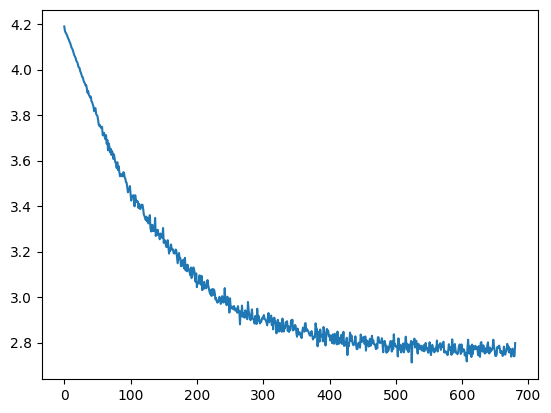

In [ ]:
from matplotlib import pyplot as plt
plt.plot(losses)
plt.show()

In [ ]:
import numpy as np
from collections import Counter
import math

# --- Load tokens from binary file ---
# Assumes uint16 tokens from vocab size 1411
tokens = np.fromfile(os.path.join(data_dir, 'train.bin'), dtype=np.uint16)

# --- Count frequency of each token ---
counts = Counter(tokens)
total = len(tokens)

# --- Compute entropy (in nats) ---
entropy = -sum((count / total) * math.log(count / total) for count in counts.values())

print(f"Empirical unigram entropy: {entropy:.4f} nats")

Empirical unigram entropy: 3.0835 nats


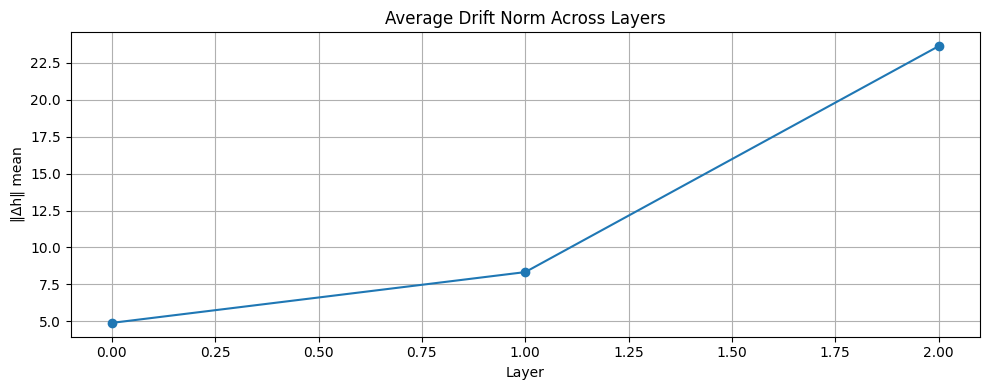

Jacobian rank (final token, projected): 66


In [23]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import grad

def compute_jacobian_rank(model, input_ids, projection_dim=133):
    """
    Compute the rank of the Jacobian of projected logits w.r.t. input embeddings
    for the final token position only, with output space optionally projected.
    """
    model.eval()
    device = input_ids.device

    # Get embeddings, set requires_grad
    emb = model.transformer.wte(input_ids)
    emb.requires_grad_(True)

    # Forward pass using embedding input
    def forward_emb(x):
        accum = 0

        for block in model.transformer.h:
            x = block(x)  # Block expects full-size input
            accum = accum + x

        x = model.transformer.ln_f(accum)
        logits = model.lm_head(x)
        return logits[:, -1, :projection_dim]

    output = forward_emb(emb)
    jacobian_rows = []

    for i in range(output.shape[-1]):
        grad_output = torch.zeros_like(output)
        grad_output[:, i] = 1.0
        grad_i = grad(output, emb, grad_outputs=grad_output, retain_graph=True)[0]
        row = grad_i[:, -1, :].detach().cpu().numpy()  # final token, last dim
        jacobian_rows.append(row.squeeze())

    J = np.stack(jacobian_rows, axis=0)  # shape: [proj_dim, emb_dim]
    rank = np.linalg.matrix_rank(J)
    return rank


def compute_drift_trajectories(model, input_ids):
    """
    Compute drift vectors Δh = h_{l+1} - h_l across transformer layers
    at each token position.
    """
    model.eval()
    x = model.transformer.wte(input_ids)
    x = model.transformer.drop(x)
    layers = []


    with torch.no_grad():
        for block in model.transformer.h:
            x = block(x)
            layers.append(x.clone())

    drifts = [layers[i+1] - layers[i] for i in range(len(layers)-1)]
    drift_norms = [d.norm(dim=-1).mean(dim=-1).cpu().numpy() for d in drifts]
    return drift_norms


def plot_drift(drift_norms):
    """
    Plot average drift norm per layer.
    """
    plt.figure(figsize=(10, 4))
    plt.plot([np.mean(d) for d in drift_norms], marker='o')
    plt.title("Average Drift Norm Across Layers")
    plt.xlabel("Layer")
    plt.ylabel("‖Δh‖ mean")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Example usage
input_ids = torch.randint(0, 66, (1, 16)).to(device)

jac_rank = compute_jacobian_rank(model, input_ids)
drift_norms = compute_drift_trajectories(model, input_ids)
plot_drift(drift_norms)

print("Jacobian rank (final token, projected):", jac_rank)


In [25]:
import torch
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def collect_drift_matrix(model, input_ids):
    """
    Stack Δh across all layers and tokens into a single matrix H ∈ [N, D],
    where each row is a flattened drift vector.
    """
    model.eval()
    x = model.transformer.wte(input_ids)
    x = model.transformer.drop(x)
    states = []
    with torch.no_grad():
        for block in model.transformer.h:
            x= block(x)
            states.append(x.clone())

    drifts = [states[i+1] - states[i] for i in range(len(states)-1)]  # list of tensors [B,T,C]
    drift_matrix = torch.cat([d.reshape(-1, d.shape[-1]).cpu() for d in drifts], dim=0)
    return drift_matrix  # shape: [N, D]

def run_drift_pca(drift_matrix, k=40):
    """
    Run PCA and report explained variance for top-k components.
    """
    pca = PCA(n_components=k)
    pca.fit(drift_matrix.numpy())
    explained = pca.explained_variance_ratio_
    return explained, pca

def plot_explained_variance(explained):
    plt.figure(figsize=(8, 4))
    plt.plot(np.cumsum(explained) * 100, marker='o')
    plt.xlabel("Principal Component")
    plt.ylabel("Cumulative Variance Explained (%)")
    plt.title("Drift Trajectory PCA: Explained Variance")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [26]:
from sklearn.mixture import GaussianMixture
import seaborn as sns

def get_projected_residuals(drift_matrix, pca):
    """
    Project Δh onto PCA space and get residuals.
    """
    proj = pca.transform(drift_matrix.numpy())
    recon = pca.inverse_transform(proj)
    residuals = drift_matrix.numpy() - recon
    return proj, residuals

def fit_gmm(proj_data, k=4):
    """
    Fit GMM to PCA-projected drift vectors to identify latent regimes.
    """
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=0)
    gmm.fit(proj_data)
    labels = gmm.predict(proj_data)
    return gmm, labels

def plot_gmm_clusters(proj_data, labels):
    """
    Plot GMM clustering over first 2 PCA components.
    """
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=proj_data[:, 0], y=proj_data[:, 1], hue=labels, palette="tab10", s=10)
    plt.title("Latent Regimes from Drift PCA (GMM Clusters)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


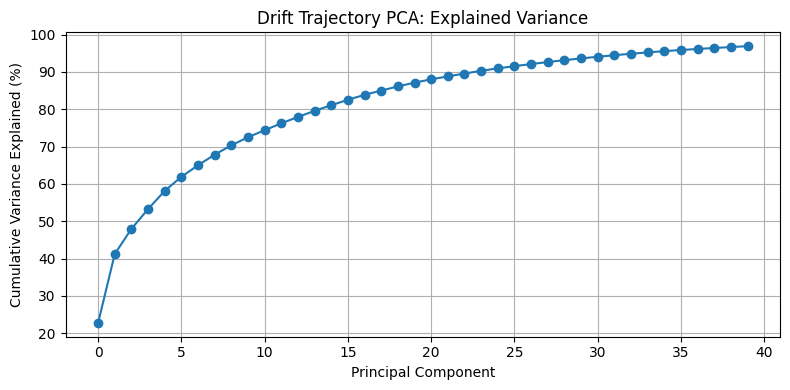

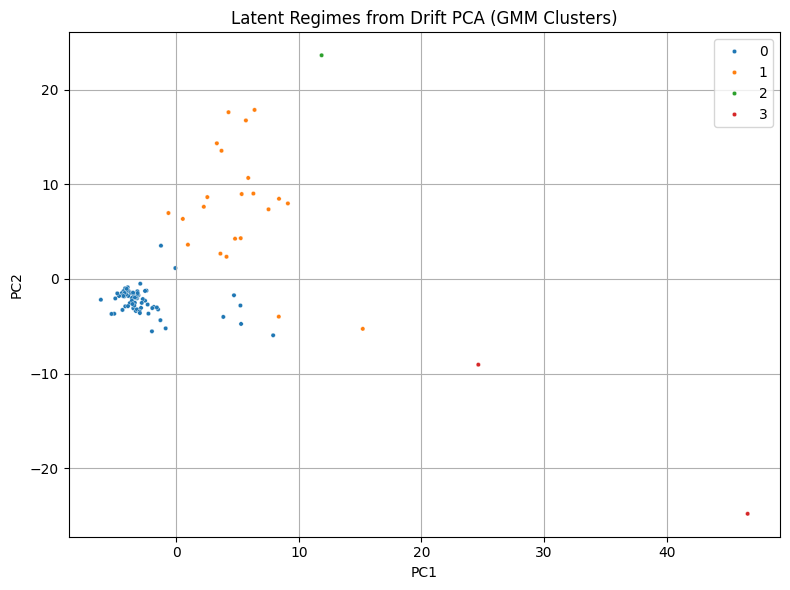

In [27]:
# Inputs
input_ids = torch.randint(0, 66, (1, 32)).to(device)

# Drift matrix
drift_matrix = collect_drift_matrix(model, input_ids)

# PCA and variance
explained, pca = run_drift_pca(drift_matrix, k=40)
plot_explained_variance(explained)

# Residuals and GMM regime fit
proj, residuals = get_projected_residuals(drift_matrix, pca)
gmm, labels = fit_gmm(proj, k=4)
plot_gmm_clusters(proj, labels)


[Baseline] Val loss: 1.4387

--- Per-Layer Ablation Report ---
Ablate Layer  0: Loss = 3.0448 | Δ = 1.6061
Ablate Layer  1: Loss = 2.2164 | Δ = 0.7777
Ablate Layer  2: Loss = 2.3889 | Δ = 0.9502
Ablate Layer  3: Loss = 2.2905 | Δ = 0.8518


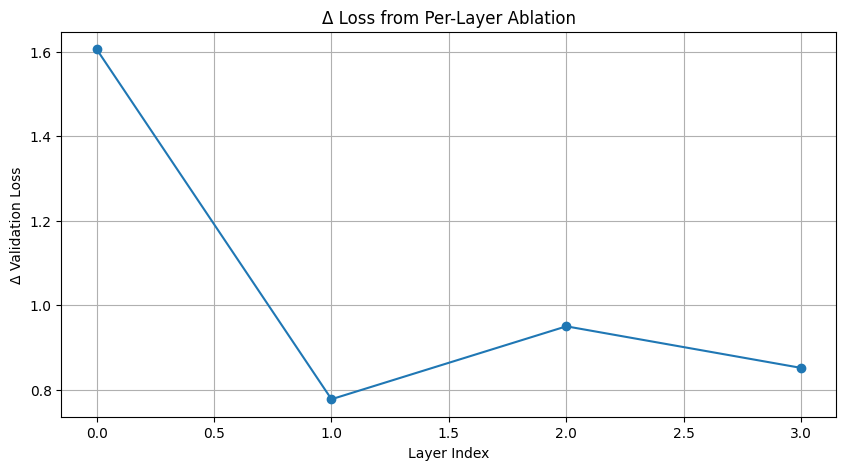

In [28]:
import matplotlib.pyplot as plt
from contextlib import contextmanager

# ==============================
# 🔁 LAYER ABLATION LOGIC BLOCK
# ==============================

@contextmanager
def layer_ablation_context(model, layers_to_ablate):
    """Context manager that safely ablates selected blocks by skipping them entirely."""
    original_forwards = [block.forward for block in model.transformer.h]

    def make_ablated_forward(index):
        def ablated_forward(x):
            # Skip this layer: identity passthrough
            return x
        return ablated_forward

    try:
        for i, block in enumerate(model.transformer.h):
            if i in layers_to_ablate:
                model.transformer.h[i].forward = make_ablated_forward(i)
        yield
    finally:
        # Always restore the original forwards
        for i, block in enumerate(model.transformer.h):
            model.transformer.h[i].forward = original_forwards[i]

@torch.no_grad()
def eval_epoch(max_batches=1):
    model.eval()
    total_loss = 0
    for i, (xb, yb) in enumerate(train_loader):
        if i >= max_batches:
            break
        xb, yb = xb[0], yb[0]
        logits, _ = model(xb, yb)
        B, T, V = logits.shape
        total_loss += criterion(logits.view(B * T, V),
                                yb.view(B * T)).item()
    return total_loss / max_batches

# ---- Evaluate baseline without any ablation ----
with layer_ablation_context(model, layers_to_ablate=set()):
    baseline_val_loss = eval_epoch()
print(f"[Baseline] Val loss: {baseline_val_loss:.4f}")

# ---- Run per-layer ablation safely ----
print("\n--- Per-Layer Ablation Report ---")
results = []
for i in range(model.config.n_layer):
    with layer_ablation_context(model, layers_to_ablate={i}):
        loss = eval_epoch()
    delta = loss - baseline_val_loss
    results.append((i, loss, delta))
    print(f"Ablate Layer {i:2d}: Loss = {loss:.4f} | Δ = {delta:.4f}")

# ---- Plotting ----
layer_ids = [i for i, _, _ in results]
delta_vals = [delta for _, _, delta in results]

plt.figure(figsize=(10, 5))
plt.plot(layer_ids, delta_vals, marker='o')
plt.title("Δ Loss from Per-Layer Ablation")
plt.xlabel("Layer Index")
plt.ylabel("Δ Validation Loss")
plt.grid(True)
plt.show()


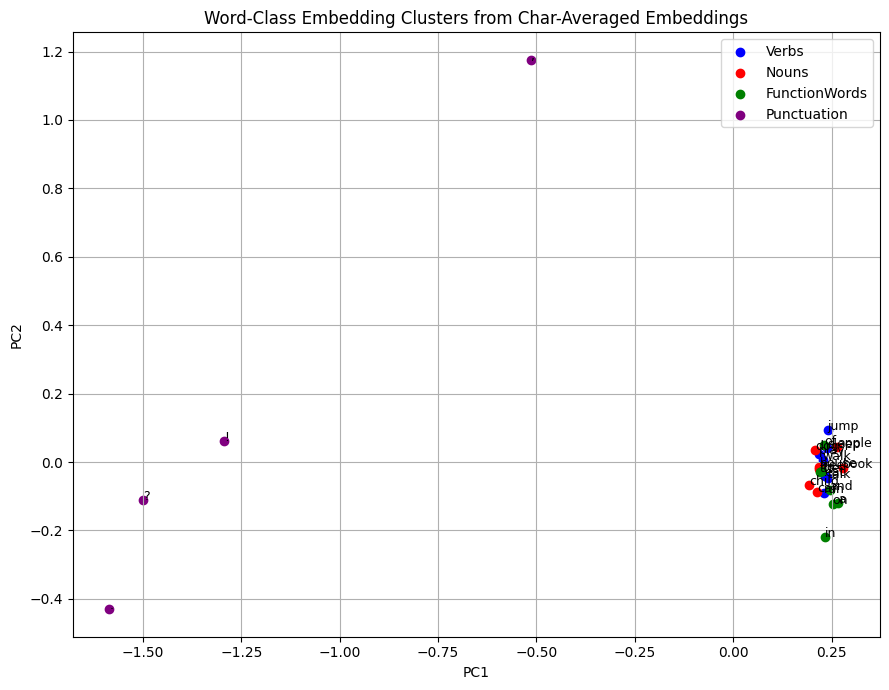

In [29]:
import torch
import pickle
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# === Load vocab ===
with open("./babylm_char_tokenized/meta.pkl", "rb") as f:
    meta = pickle.load(f)

stoi = meta["stoi"]
itos = meta["itos"]

# === Define categories ===
categories = {
    "Verbs": ["play", "run", "eat", "sleep", "jump", "talk", "walk"],
    "Nouns": ["dog", "tree", "car", "book", "child", "house", "apple"],
    "FunctionWords": ["the", "and", "in", "on", "to", "of", "a"],
    "Punctuation": [".", ",", "!", "?"]
}

# === Extract model embedding table ===
device = next(model.parameters()).device
wte = model.transformer.wte  # (vocab_size, d_model)

word_embeddings = []
labels = []
words = []

def get_char_embedding(word):
    try:
        ids = [stoi[c] for c in word if c in stoi]
        if not ids:
            return None
        with torch.no_grad():
            embeds = wte(torch.tensor(ids, dtype=torch.long, device=device))  # (len, d)
            return embeds.mean(dim=0).cpu().numpy()
    except KeyError:
        return None

# === Gather embeddings ===
for category, word_list in categories.items():
    for word in word_list:
        emb = get_char_embedding(word)
        if emb is not None:
            word_embeddings.append(emb)
            labels.append(category)
            words.append(word)

# === PCA projection ===
pca = PCA(n_components=2)
proj = pca.fit_transform(word_embeddings)

# === Plotting ===
colors = {
    "Verbs": "blue",
    "Nouns": "red",
    "FunctionWords": "green",
    "Punctuation": "purple"
}

plt.figure(figsize=(9, 7))
for category in categories:
    idxs = [i for i, l in enumerate(labels) if l == category]
    plt.scatter(proj[idxs, 0], proj[idxs, 1], label=category, color=colors[category])
    for i in idxs:
        plt.text(proj[i, 0], proj[i, 1], words[i], fontsize=9)

plt.legend()
plt.title("Word-Class Embedding Clusters from Char-Averaged Embeddings")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.tight_layout()
plt.show()


🔍 Probe: ['walk', 'walks', 'run', 'runs'] vs tree


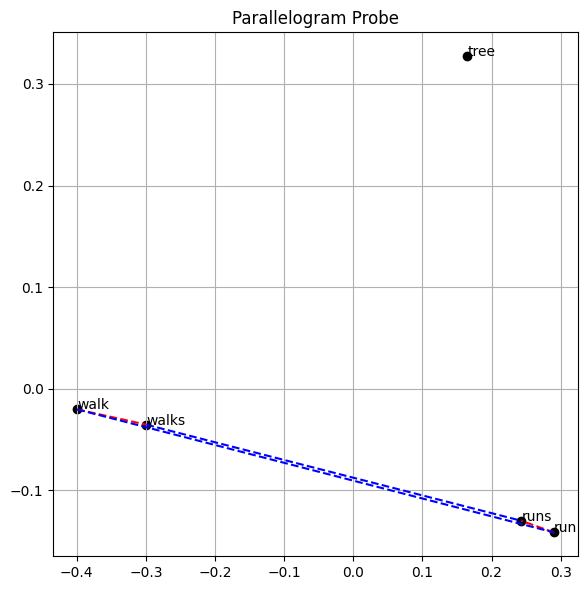


🔍 Probe: ['book', 'books', 'dog', 'dogs'] vs car


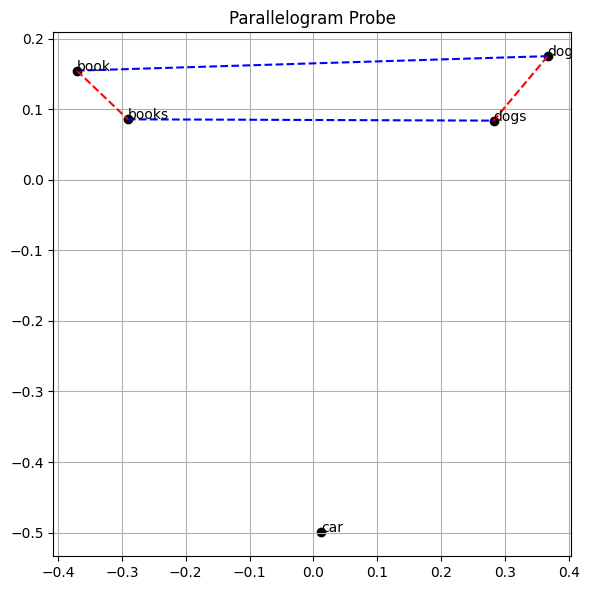


🔍 Probe: ['happy', 'unhappy', 'fair', 'unfair'] vs table


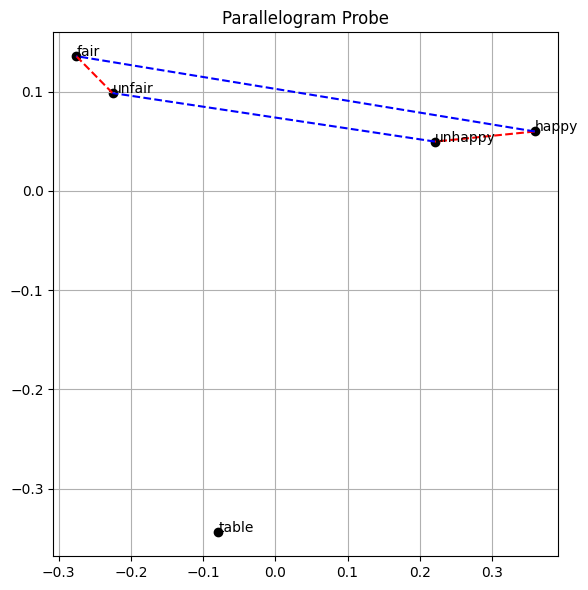


🔍 Probe: ['king', 'queen', 'man', 'woman'] vs apple


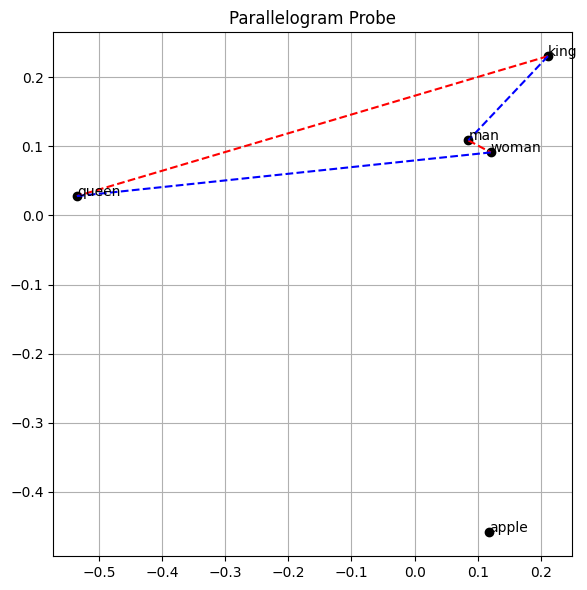


🔍 Probe: ['color', 'colour', 'honor', 'honour'] vs book


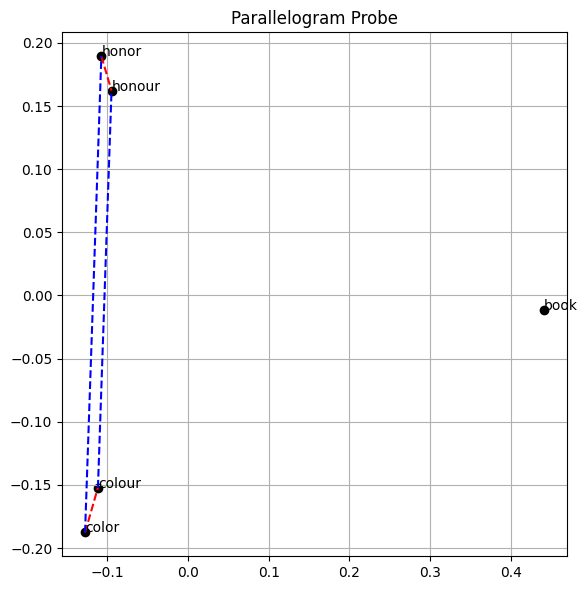


🔍 Probe: ['child', 'children', 'man', 'men'] vs stone


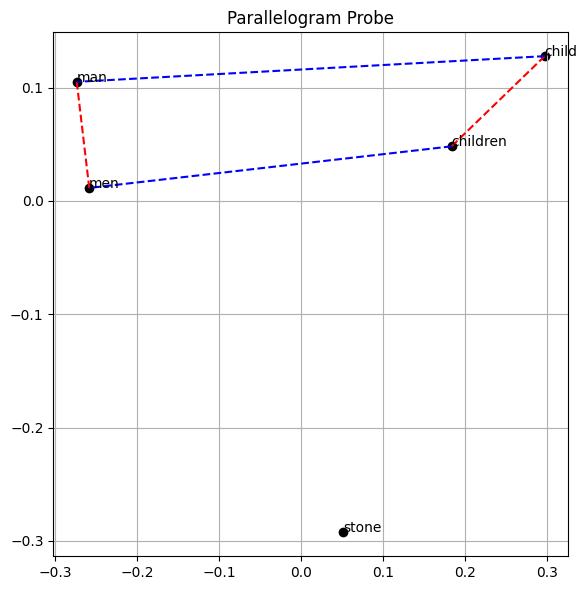


🔍 Probe: ['run', 'runner', 'swim', 'swimmer'] vs tree


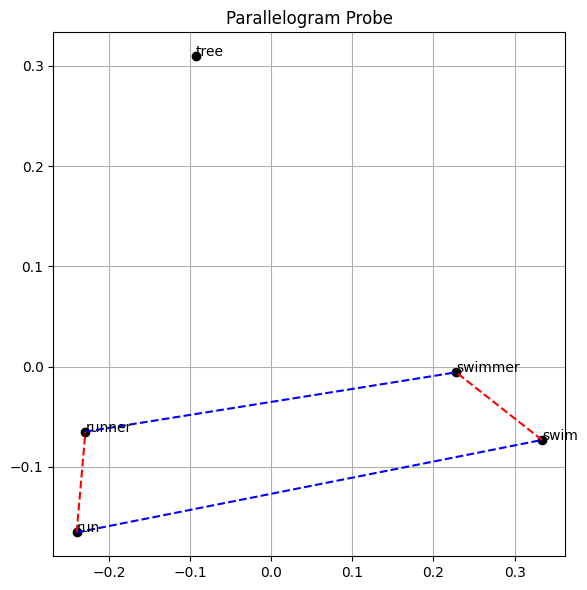


🔍 Probe: ['to', 'from', 'in', 'out'] vs the


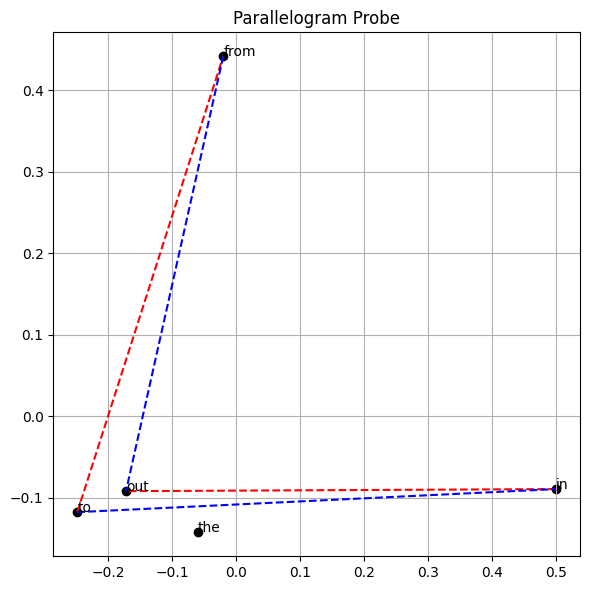

In [30]:
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# === Load vocab ===
with open("./babylm_char_tokenized/meta.pkl", "rb") as f:
    meta = pickle.load(f)

stoi = meta["stoi"]
itos = meta["itos"]
device = next(model.parameters()).device
wte = model.transformer.wte

# === Char embedding extractor ===
def get_char_embedding(word):
    ids = [stoi[c] for c in word if c in stoi]
    if not ids:
        return None
    with torch.no_grad():
        embeds = wte(torch.tensor(ids, dtype=torch.long, device=device))  # (len, d)
        return embeds.mean(dim=0).cpu().numpy()

# === Plot one parallelogram ===
def plot_parallelogram(words, outlier=None):
    vecs = [get_char_embedding(w) for w in words]
    labels = words.copy()
    if outlier:
        vecs.append(get_char_embedding(outlier))
        labels.append(outlier)

    # drop None values
    vecs = [v for v in vecs if v is not None]
    if len(vecs) < 4:
        print(f"⚠️ Not enough valid embeddings for: {labels}")
        return

    vecs = np.stack(vecs)
    proj = PCA(n_components=2).fit_transform(vecs)

    plt.figure(figsize=(6, 6))
    plt.scatter(proj[:, 0], proj[:, 1], color='black')
    for i, label in enumerate(labels):
        plt.text(proj[i, 0], proj[i, 1], label, fontsize=10)

    if len(proj) >= 4:
        A, B, C, D = proj[:4]
        plt.plot([A[0], B[0]], [A[1], B[1]], 'r--')
        plt.plot([C[0], D[0]], [C[1], D[1]], 'r--')
        plt.plot([A[0], C[0]], [A[1], C[1]], 'b--')
        plt.plot([B[0], D[0]], [B[1], D[1]], 'b--')

    plt.title("Parallelogram Probe")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# === Define test sets ===
test_sets = [
    (["walk", "walks", "run", "runs"], "tree"),               # verb→third person
    (["book", "books", "dog", "dogs"], "car"),               # singular→plural
    (["happy", "unhappy", "fair", "unfair"], "table"),       # negation prefix
    (["king", "queen", "man", "woman"], "apple"),            # gender pairs
    (["color", "colour", "honor", "honour"], "book"),        # spelling variants
    (["child", "children", "man", "men"], "stone"),          # irregular plurals
    (["run", "runner", "swim", "swimmer"], "tree"),          # verb→agent noun
    (["to", "from", "in", "out"], "the"),                    # function-word symmetry
]

# === Run all probes ===
for words, outlier in test_sets:
    print(f"\n🔍 Probe: {words} vs {outlier}")
    plot_parallelogram(words, outlier)


note: "to", "from", "in", "out" do not behave as parallel directional operators in Shakespeare. They will distinctly show a NON-typical presentation."to be or not to be" etc

In [31]:
def decode_chars(token_ids, itos):
    """
    Decodes a list of character token IDs into a string.
    """
    return ''.join([itos[i] for i in token_ids])

def encode_chars(text, stoi):
    """
    Encodes a string into a list of token IDs, one per character.
    """
    return [stoi.get(c, 0) for c in text]


def fenchel_decode(logits, tau=1.0, iters=3):
    """
    Fenchel-decoded logits -> smoothed probability distribution.
    """
    energy = -logits
    p = torch.full_like(energy, 1.0 / energy.size(-1))
    for _ in range(iters):
        p = torch.softmax((-energy / tau) + p.log(), dim=-1)
    return p

def decode_sequence_char(
    model, stoi, itos, prompt, max_new_tokens=100, block_size=256,
    use_fenchel=False, tau=1.0, fenchel_iters=3, temperature=1.0
):
    """
    Character-level decoding from a prompt using the model's logits.
    """
    model.eval()
    device = next(model.parameters()).device
    start_ids = encode_chars(prompt, stoi)
    idx = torch.tensor([start_ids], dtype=torch.long).to(device)

    for _ in range(max_new_tokens):
        context = idx[:, -block_size:]
        logits, _ = model(context)
        last_logits = logits[:, -1, :]

        if use_fenchel:
            probs = fenchel_decode(last_logits, tau=tau, iters=fenchel_iters)
        else:
            probs = torch.softmax(last_logits / temperature, dim=-1)

        next_token = torch.multinomial(probs, num_samples=1)
        idx = torch.cat([idx, next_token], dim=1)

    return decode_chars(idx[0].tolist(), itos)

In [33]:
import pickle

with open("./babylm_char_tokenized/meta.pkl", "rb") as f:
    meta = pickle.load(f)
stoi = meta["stoi"]
itos = meta["itos"]

prompt = "ROMEO: What light through yonder window breaks?"
generated = decode_sequence_char(
    model=model,
    stoi=stoi,
    itos=itos,
    prompt=prompt,
    max_new_tokens=1024,
    block_size=256,
    use_fenchel=False,
    tau=1.5,
    fenchel_iters=2,
    temperature=1.0
)

print(generated)


ROMEO: What light through yonder window breaks?
First I men sometime: those is all?
How shall Angelo, but 'strength what York,
Shall with your help, I am eath tender of,
Which and is in you.
3 KING RICHARD II:
Breat man's good thou his rich misiders.
His that life that do gods the heavy weep:
I'll your frowns on the plown in throble,
Away's here serve, in lady, to me thou wert;
Or is it not husbandance of bone of enjoy
As man, we was, down he ere your seals,
And true of howe of fill these saves, not be lord,
Seeker hearts, thou shalt not, with, my life,
But 'tis this knews the proud resising justice
For a prugh sprincess that word up hope,
The honour. I wish him furthen being to go.

Nurse:
Yous! our imbfoul; Let my sman?

DUKE VINCENTIO:
The have, procely! The torgue case unficts lives. Have,
Of it is repeised of the Duke of Nenest;
My sing-sarried and Our: what whom, He'sI say,
Knows the goodbulieted.

BUCKINGHAM:
You Lets Hasting imost me spitit; sir, and I.

BULOHMENENIUS:
On i' we

In [ ]:
import pickle

with open("./babylm_char_tokenized/meta.pkl", "rb") as f:
    meta = pickle.load(f)
stoi = meta["stoi"]
itos = meta["itos"]

prompt = "Once upon a time in a small forest, a rabbit woke up and stretched. He looked around and said, Good morning, world! Then he..."
generated = decode_sequence_char(
    model=model,
    stoi=stoi,
    itos=itos,
    prompt=prompt,
    max_new_tokens=1024,
    block_size=512,
    use_fenchel=False,
    tau=1.5,
    fenchel_iters=2,
    temperature=1.0
)

print(generated)


Once upon a time in a small forest, a rabbit woke up and stretched. He looked around and said, Good morning, world! Then he...

Ełvy: so mind?
If it's no longeen, sir, to pay no brat, truth:
Why, now thus, what I am; that I do fly, my lords!

A, I'll hook no doubt.

Second Musician:
Then, who have ill, and then they not roll some shadow'd narrar!
You know this hard to multive again.
From a sweet queer sails,
Or with the story you, your weeping caste, thy londer;
For many your proposed husbands on the calf
Where I can go special issue the cause to spructuals:
When I do entreat you to set it.
Even if I shall make upon thy captain,
draw, flown, and, and Wern twitch the spake.

PRINCE EDWARD:
Prenties like to put them into this powers.

KING EDWARD IV:
And help, these commoder foe, is it, dearly and served crown?

First Citizen:
I should love thee, sir, I get to-morrow:
Transcendent, gentleman, to be trabbled bloodth.
Then she is prudent that fetch sats me,
And her resolution touch and thr

In [ ]:
import pickle

with open("./babylm_char_tokenized/meta.pkl", "rb") as f:
    meta = pickle.load(f)
stoi = meta["stoi"]
itos = meta["itos"]

prompt = "The Nile is the longest river in the world, flowing through multiple countries in Africa. It begins in"
generated = decode_sequence_char(
    model=model,
    stoi=stoi,
    itos=itos,
    prompt=prompt,
    max_new_tokens=1024,
    block_size=512,
    use_fenchel=False,
    tau=1.5,
    fenchel_iters=2,
    temperature=1.0
)

print(generated)


The Nile is the longest river in the world, flowing through multiple countries in Africa. It begins in our knee of
can tense bodies, deeply thy power,
And review the likewise for guess 'Where
It aged the book pulls it away: I little boy?
Boy, torrestrae! do we make me among I the chequin with
Bread death;--early To pardon,
And how this undeisant, 'Barnardine and
Measure: I'd not, if I must wipe for surprise; nor the
pounds they had special willow the fair Oxford;
My sun's preference. Well, Bole, let me now.
And likely demmy, in part I must express
Our great branch is old.

NOLIO:
O you guide for redeem's weal. Kings made anjire
More grother, and so far to the earth itself for
general wombs-time made distress born you,
I do come, with the probles this known in their course,
I bide you inferior made upon me to Montague:
We must be wanted upon my brother against God's heart,
But made me my pock on one reason in the uncle
My gustle note hardly, I hadst used the earth.
Not provest it late i

In [ ]:
import pickle

with open("./babylm_char_tokenized/meta.pkl", "rb") as f:
    meta = pickle.load(f)
stoi = meta["stoi"]
itos = meta["itos"]

prompt = "In a surprising turn of events, the mayor announced a new initiative to support small businesses."
generated = decode_sequence_char(
    model=model,
    stoi=stoi,
    itos=itos,
    prompt=prompt,
    max_new_tokens=1024,
    block_size=512,
    use_fenchel=False,
    tau=1.5,
    fenchel_iters=2,
    temperature=1.0
)

print(generated)


In a surprising turn of events, the mayor announced a new initiative to support small businesses.
Commy is willingly true: fill in as there come down!
Gently came know, now below the man
Who had almost thinks and Entertain Henry's affairs;
And in the battlesness cannot to learn her!
Adult of blood any rather lips shone with the ulfilted,
She walked to; her man to flatter grow man:
Its Faintness; and suspect? look into beautiful cursed,
Like my branches my eye in the captain still
Is no vice more; Boup Rusely.
But so to made me comfort, Was dreary; swear.

GLOUCESTER:
Hark way around shed: the court, I shall for many times;
In Grace.
оo God till' the plucks of ice.

PETER:
This is music is clear.

BUCKINGHAM:
Play me part to Romeo: I was sent you fight.
By slain boat, come back and prophes?

제ill:
Haffill; my master's writing for's advocate
By skyscraper with free washfires bespectator, fresh moldstrel;
quite furnish to same remainber and great man
art born, good man.tear dear, please, 

In [ ]:
import torch, torch.nn as nn
from torch.nn import functional as F

class RKTriad(nn.Module):
    """Runge-Kutta integrator that jointly evolves a (K,Q,V) triad."""
    def __init__(self, dim, h=0.1):
        super().__init__()
        self.h = h
        self.mlp = nn.Sequential(
            nn.Linear(3*dim, 4*dim),
            nn.GELU(),
            nn.Linear(4*dim, dim)
        )

    def _rk_step(self, k, q, v):
        cat = torch.cat([k, q, v,
                         q, v, k,
                         v, k, q], dim=-1)          # 3 permutations
        B,T,_ = cat.shape
        flat  = cat.view(3*B*T, -1)
        out   = self.mlp(flat).view(3, B, T, -1)
        return out[0], out[1], out[2]

    def forward(self, k, q, v):
        d1k,d1q,d1v = self._rk_step(k,q,v)
        k1,q1,v1    = k+self.h*d1k, q+self.h*d1q, v+self.h*d1v
        d2k,d2q,d2v = self._rk_step(k1,q1,v1)
        k2 = k + 0.5*self.h*(d1k+d2k)
        q2 = q + 0.5*self.h*(d1q+d2q)
        v2 = v + 0.5*self.h*(d1v+d2v)
        return k2,q2,v2

class FeedbackOscillator(nn.Module):
    """
    Pure feedback system:
      1) triad mix inside 'block'  (stage A)
      2) triad mix on combined output (stage B)
      3) triad mix again, then weighted merge to produce x_out (stage C)
    """
    def __init__(self, dim, weight=0.5):
        super().__init__()
        self.dim = dim
        self.weight = weight
        self.mixA = RKTriad(dim)
        self.mixB = RKTriad(dim)
        self.mixC = RKTriad(dim)

    def _split(self, x):
        return x.split(self.dim, dim=-1)            # K,Q,V

    def _cat(self, k,q,v):
        return torch.cat([k,q,v], dim=-1)

    def forward(self, x):
        k,q,v = self._split(x)                      # Stage A
        k,q,v = self.mixA(k,q,v)
        xA    = self._cat(k,q,v)

        k,q,v = self._split(xA)                     # Stage B
        k,q,v = self.mixB(k,q,v)
        xB    = self._cat(k,q,v)

        k,q,v = self._split(xB)                     # Stage C
        k,q,v = self.mixC(k,q,v)
        xC    = self._cat(k,q,v)

        # forced weighting: residual push–pull
        return (1-self.weight)*x + self.weight*xC


00  mean -0.0081   std 1.0001
01  mean -0.0097   std 1.0005
02  mean -0.0114   std 1.0012
03  mean -0.0132   std 1.0022
04  mean -0.0150   std 1.0035
05  mean -0.0168   std 1.0051
06  mean -0.0186   std 1.0070
07  mean -0.0205   std 1.0093
08  mean -0.0224   std 1.0118
09  mean -0.0244   std 1.0146
10  mean -0.0265   std 1.0178
11  mean -0.0285   std 1.0212
12  mean -0.0307   std 1.0250
13  mean -0.0329   std 1.0291
14  mean -0.0351   std 1.0334
15  mean -0.0374   std 1.0381
16  mean -0.0398   std 1.0431
17  mean -0.0422   std 1.0485
18  mean -0.0447   std 1.0541
19  mean -0.0472   std 1.0601
20  mean -0.0499   std 1.0663
21  mean -0.0526   std 1.0729
22  mean -0.0554   std 1.0798
23  mean -0.0582   std 1.0871
24  mean -0.0611   std 1.0947
25  mean -0.0642   std 1.1025
26  mean -0.0673   std 1.1108
27  mean -0.0705   std 1.1193
28  mean -0.0737   std 1.1282
29  mean -0.0771   std 1.1374
30  mean -0.0806   std 1.1470
31  mean -0.0842   std 1.1569
32  mean -0.0878   std 1.1672
33  mean -

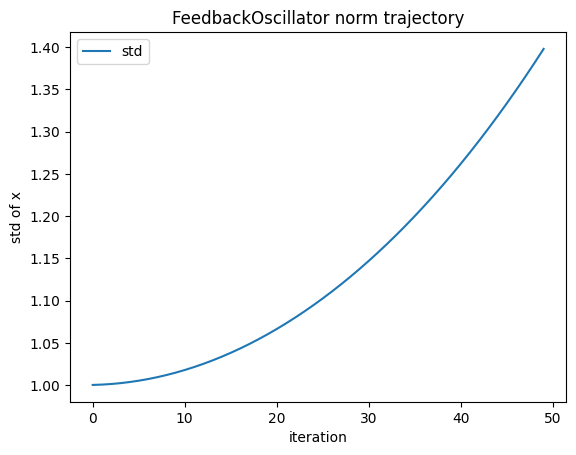

In [ ]:
def main():
    B, T, head_dim = 2, 64, 32            # batch, sequence, per-role dim
    steps          = 50                   # number of feedback iterations
    osc            = FeedbackOscillator(head_dim, weight=0.5)
    x              = torch.randn(B, T, 3 * head_dim)   # 3·D input → (K,Q,V) triad

    traj_std = []                         # track std-dev over time
    traj_mu  = []                         # track mean over time

    with torch.no_grad():
        for s in range(steps):
            x = osc(x)
            traj_std.append(x.std().item())
            traj_mu.append(x.mean().item())
            print(f"{s:02d}  mean {traj_mu[-1]:+.4f}   std {traj_std[-1]:.4f}")

    # quick visual: trajectory of std to see convergence / divergence
    plt.plot(traj_std, label="std")
    plt.xlabel("iteration")
    plt.ylabel("std of x")
    plt.title("FeedbackOscillator norm trajectory")
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TriadicFeedbackCore(nn.Module):
    def __init__(self, dim, h=0.1, forced_weights=(0.5, 0.3, 0.2)):
        super().__init__()
        self.h = h
        self.alpha, self.beta, self.gamma = forced_weights

        self.mlp = nn.Sequential(
            nn.Linear(3 * dim, 4 * dim),
            nn.GELU(),
            nn.Linear(4 * dim, dim)
        )

        self.mlp_static = nn.Sequential(
            nn.Linear(3 * dim, 4 * dim),
            nn.GELU(),
            nn.Linear(4 * dim, dim)
        )

        # We'll sync static weights after init
        self.sync_static()

    def sync_static(self):
        """Copy weights from the main MLP to the static MLP and detach."""
        self.mlp_static.load_state_dict(self.mlp.state_dict())
        for param in self.mlp_static.parameters():
            param.requires_grad = False

    def rk_step(self, K, Q, V):
        cat1 = torch.cat([K, Q, V], dim=-1)
        cat2 = torch.cat([Q, V, K], dim=-1)
        cat3 = torch.cat([V, K, Q], dim=-1)
        x = torch.cat([cat1, cat2, cat3], dim=0)
        out = self.mlp(x)
        return out.chunk(3, dim=0)

    def forward(self, K, Q, V, steps=1):
        for _ in range(steps):
            # First step
            dK1, dQ1, dV1 = self.rk_step(K, Q, V)
            K1 = K + self.h * dK1
            Q1 = Q + self.h * dQ1
            V1 = V + self.h * dV1

            # Second step
            dK2, dQ2, dV2 = self.rk_step(K1, Q1, V1)

            # RK2 update
            K = K + self.h * 0.5 * (dK1 + dK2)
            Q = Q + self.h * 0.5 * (dQ1 + dQ2)
            V = V + self.h * 0.5 * (dV1 + dV2)

            # Static feedback with frozen weights
            cat_static = torch.cat([K, Q, V], dim=-1)
            feedback = self.mlp_static(cat_static)

            # Forced weighted output projection
            K = self.alpha * K + feedback
            Q = self.beta  * Q + feedback
            V = self.gamma * V + feedback

        return K, Q, V


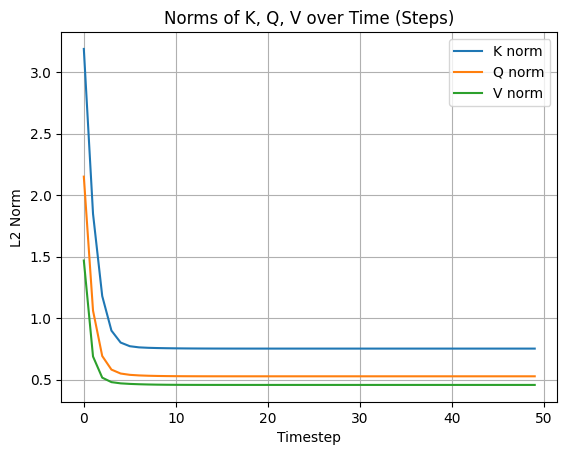

In [ ]:
import torch
import matplotlib.pyplot as plt

# Redefine the minimal fixed core for plotting
class TriadicFeedbackCore(nn.Module):
    def __init__(self, dim, h=0.1, forced_weights=(0.5, 0.3, 0.2)):
        super().__init__()
        self.h = h
        self.alpha, self.beta, self.gamma = forced_weights

        self.mlp = nn.Sequential(
            nn.Linear(3 * dim, 4 * dim),
            nn.GELU(),
            nn.Linear(4 * dim, dim)
        )

        self.mlp_static = nn.Sequential(
            nn.Linear(3 * dim, 4 * dim),
            nn.GELU(),
            nn.Linear(4 * dim, dim)
        )
        self.sync_static()

    def sync_static(self):
        self.mlp_static.load_state_dict(self.mlp.state_dict())
        for param in self.mlp_static.parameters():
            param.requires_grad = False

    def rk_step(self, K, Q, V):
        cat1 = torch.cat([K, Q, V], dim=-1)
        cat2 = torch.cat([Q, V, K], dim=-1)
        cat3 = torch.cat([V, K, Q], dim=-1)
        x = torch.cat([cat1, cat2, cat3], dim=0)
        out = self.mlp(x)
        return out.chunk(3, dim=0)

    def forward(self, K, Q, V, steps=1):
        for _ in range(steps):
            dK1, dQ1, dV1 = self.rk_step(K, Q, V)
            K1 = K + self.h * dK1
            Q1 = Q + self.h * dQ1
            V1 = V + self.h * dV1

            dK2, dQ2, dV2 = self.rk_step(K1, Q1, V1)

            K = K + self.h * 0.5 * (dK1 + dK2)
            Q = Q + self.h * 0.5 * (dQ1 + dQ2)
            V = V + self.h * 0.5 * (dV1 + dV2)

            feedback = self.mlp_static(torch.cat([K, Q, V], dim=-1))

            K = self.alpha * K + feedback
            Q = self.beta  * Q + feedback
            V = self.gamma * V + feedback

        return K, Q, V

# Setup and run
dim = 32
core = TriadicFeedbackCore(dim)

K = torch.randn(dim)
Q = torch.randn(dim)
V = torch.randn(dim)

trajectory = []
for _ in range(50):
    K, Q, V = [x.unsqueeze(0) for x in (K, Q, V)]
    K, Q, V = core(K, Q, V, steps=1)
    K, Q, V = [x.squeeze(0) for x in (K, Q, V)]
    trajectory.append((K.clone(), Q.clone(), V.clone()))

# Compute L2 norms over time
K_norms = [x.norm().item() for x, _, _ in trajectory]
Q_norms = [x.norm().item() for _, x, _ in trajectory]
V_norms = [x.norm().item() for _, _, x in trajectory]

# Plot
plt.plot(K_norms, label='K norm')
plt.plot(Q_norms, label='Q norm')
plt.plot(V_norms, label='V norm')
plt.title("Norms of K, Q, V over Time (Steps)")
plt.xlabel("Timestep")
plt.ylabel("L2 Norm")
plt.legend()
plt.grid(True)
plt.show()


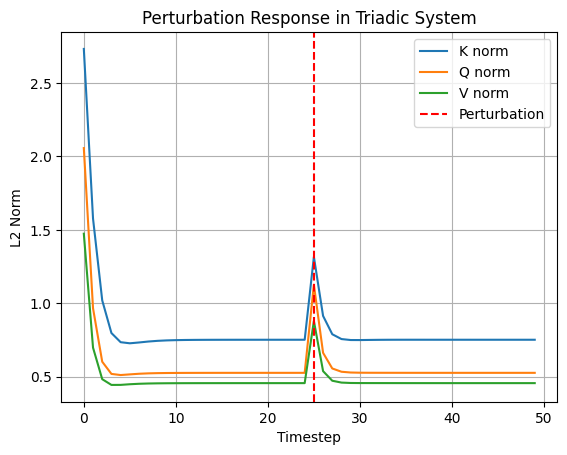

In [ ]:
import matplotlib.pyplot as plt

# Reset initial state
K = torch.randn(dim)
Q = torch.randn(dim)
V = torch.randn(dim)

K_norms, Q_norms, V_norms = [], [], []

for step in range(50):
    if step == 25:
        # Inject perturbation (noise burst)
        noise = lambda: 0.5 * torch.randn_like(K)
        K += noise()
        Q += noise()
        V += noise()

    K, Q, V = [x.unsqueeze(0) for x in (K, Q, V)]
    K, Q, V = core(K, Q, V, steps=1)
    K, Q, V = [x.squeeze(0) for x in (K, Q, V)]

    K_norms.append(K.norm().item())
    Q_norms.append(Q.norm().item())
    V_norms.append(V.norm().item())

# Plot with vertical marker at perturbation step
plt.plot(K_norms, label='K norm')
plt.plot(Q_norms, label='Q norm')
plt.plot(V_norms, label='V norm')
plt.axvline(x=25, color='red', linestyle='--', label='Perturbation')
plt.title("Perturbation Response in Triadic System")
plt.xlabel("Timestep")
plt.ylabel("L2 Norm")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
!pip install python-Levenshtein


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [python-Levenshtein]


In [ ]:
import os, pickle, random, re, json
from collections import Counter
from pathlib import Path

import numpy as np
import torch
import Levenshtein as lev

# ------------------------------------------------------------------
# 🔧 1.  LOAD CHAR-LEVEL VOCAB (same meta.pkl you used for training)
# ------------------------------------------------------------------
META_PATH = "./babylm_char_tokenized/meta.pkl"      # change if needed
with open(META_PATH, "rb") as f:
    meta = pickle.load(f)
stoi : dict[str,int] = meta["stoi"]        # char → id
itos : dict[int,str] = meta["itos"]        # id   → char

vocab_size = meta["vocab_size"]            # should be 66
assert len(stoi) == vocab_size

def encode(text:str):
    # unknown chars fall back to space (or pick any safe token)
    unk = stoi.get(" ", 0)
    return torch.tensor([[stoi.get(ch, unk) for ch in text]], dtype=torch.long)

def decode(ids:torch.Tensor|list[int]):
    if isinstance(ids, torch.Tensor):
        ids = ids.tolist()
    return "".join(itos[i] for i in ids)

# ------------------------------------------------------------------
# 🔧 2.  SAMPLING HELPERS  (character model uses same .generate)
# ------------------------------------------------------------------
@torch.no_grad()
def generate_once(prompt:str, max_new:int=256,
                  temperature:float=1.0, top_k:int|None=None):
    prompt_ids = encode(prompt)
    gen_ids = model.generate(prompt_ids, max_new_tokens=max_new,
                             temperature=temperature, top_k=top_k)
    new_part = gen_ids[:, prompt_ids.shape[1]:]          # skip the prompt
    return decode(new_part.squeeze(0))

def generate_many(prompt:str, n:int, **kw):
    return [ generate_once(prompt, **kw) for _ in range(n) ]

# ------------------------------------------------------------------
# 🔧 3.  METRICS
# ------------------------------------------------------------------
TAG_RE  = re.compile(r"<\s*/?\s*([a-zA-Z0-9:_-]+)")
SPK_RE  = re.compile(r"([A-Z][A-Z0-9]+):")

def prefix_of(line:str) -> str:
    line = line.strip()
    if not line: return ""
    m = TAG_RE.match(line)
    if m: return m.group(1).lower()
    m = SPK_RE.match(line)
    if m: return m.group(1)
    return line.split()[0].lower()

def template_compression_ratio(texts:list[str], k:int=5) -> float:
    pref = [prefix_of(ln) for txt in texts for ln in txt.splitlines() if ln.strip()]
    cnt  = Counter(pref)
    if not cnt: return 0.0
    topk = sum(v for _,v in cnt.most_common(k))
    return topk / sum(cnt.values())

def syntactic_entropy(texts:list[str]) -> float:
    tokens = [ch for txt in texts for ch in txt]         # char-level entropy
    cnt = Counter(tokens)
    probs = np.array(list(cnt.values()), dtype=float)
    probs /= probs.sum()
    return float(-(probs * np.log2(probs + 1e-12)).sum())

def levenshtein_pull(texts:list[str], baseline_templates:set[str]) -> float:
    dists = []
    for txt in texts:
        for ln in txt.splitlines():
            p = prefix_of(ln)
            if not p: continue
            best = min( lev.distance(p, b) for b in baseline_templates )
            dists.append(best)
    return float(np.mean(dists)) if dists else 0.0

# ------------------------------------------------------------------
# 🔧 4.  NOISY CONTEXT GENERATOR
# ------------------------------------------------------------------
RARE = ["Zounds", "Marry", "Prithee", "’sblood", "Fie", "Alack", "Gramercy"]
def noisy_prompt(base:str) -> str:
    spice = random.choice(RARE)
    if random.random() < 0.5:
        return spice + base.lower()
    return base[::-1] + spice

# ------------------------------------------------------------------
# 🔧 5.  EXPERIMENT
# ------------------------------------------------------------------
def run_symbol_collapse(
        base_prompt:str="ROMEO:",
        nsamp:int=64,
        max_new:int=256,
        temperature:float=1.0,
        top_k:int|None=None):

    # -- baseline (dropout OFF) ---------------------------
    model.eval()
    baseline = generate_many(base_prompt, nsamp,
                             max_new=max_new,
                             temperature=temperature, top_k=top_k)

    templates = { prefix_of(ln)
                  for txt in baseline
                  for ln in txt.splitlines() if ln.strip() }

    # -- dropout ON --------------------------------------
    model.train()                                        # activates dropout (0.1)
    dropout_out = generate_many(base_prompt, nsamp,
                                max_new=max_new,
                                temperature=temperature, top_k=top_k)

    # -- noisy context -----------------------------------
    model.eval()
    noise_out = []
    for _ in range(nsamp):
        ctx = noisy_prompt(base_prompt)
        noise_out.append( generate_once(ctx, max_new=max_new,
                                        temperature=temperature, top_k=top_k) )

    # -- metrics -----------------------------------------
    res = {}
    for name, texts in [("baseline", baseline),
                        ("dropout",  dropout_out),
                        ("noise",    noise_out)]:
        res[name] = dict(
            TCR   = template_compression_ratio(texts),
            H_s   = syntactic_entropy(texts),
            L_dist= levenshtein_pull(texts, templates),
        )
    return res

# ------------------------------------------------------------------
# 🔧 6.  RUN & REPORT
# ------------------------------------------------------------------
if __name__ == "__main__":
    # make sure model lives on CPU
    model.to("cpu")

    results = run_symbol_collapse(
        base_prompt="ACT I SCENE I:",
        nsamp=16,
        max_new=256,
        temperature=1.0,
        top_k=None
    )

    print(json.dumps(results, indent=2))

{
  "baseline": {
    "TCR": 0.1885245901639344,
    "H_s": 4.714138961842586,
    "L_dist": 0.0
  },
  "dropout": {
    "TCR": 0.171875,
    "H_s": 4.757562597943566,
    "L_dist": 1.5703125
  },
  "noise": {
    "TCR": 0.15037593984962405,
    "H_s": 4.682929747304073,
    "L_dist": 1.4586466165413534
  }
}
